In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import pickle
import json
import numpy as np
from scipy import spatial
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
epochs = 15
batch_size = 30
image_dimension = 300

In [ ]:
# Input layer
input_img = Input(shape=(image_dimension, image_dimension, 3))

# Encoding layers
x = Conv2D(512, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((3, 3), padding='same', name='encoded_layer')(x)

# Decoding layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((3, 3))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Instanstiate Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [ ]:
# View parameter summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 512)     14336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 512)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      294976    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 16)        9232      
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 25, 25, 16)        0     

In [ ]:
# Directories for images
base_directory = '/content/drive/My Drive/ds/pizza_images/autoencoder/yelp_only'
training_directory = os.path.join(os.path.join(base_directory, 'train/data'),'')
validation_directory = os.path.join(os.path.join(base_directory, 'validate/data'),'')
test_directory = os.path.join(os.path.join(base_directory, 'test/data'),'')

In [ ]:
# Sample files used to train model drawn from all images
sample_size = 1600
allimage_directory = '/content/drive/MyDrive/ds/pizza_images/yelp_only/data'
allimage_directory = os.path.join(allimage_directory,'')
total_image_count = len([name for name in os.listdir(allimage_directory)])
all_image_names = os.listdir(allimage_directory)
# sample_indices = np.random.randint(0, total_image_count, size=sample_size)
# training_sample_indices = sample_indices[:int(sample_size*.8)]
# validation_sample_indices = sample_indices[int(sample_size*.8):]

In [ ]:
# Copy images into training and validation folders
from shutil import copy2
for training_sample_index in training_sample_indices:
    copy2(allimage_directory +  all_image_names[training_sample_index], training_directory + all_image_names[training_sample_index])
for validation_sample_index in validation_sample_indices:
    copy2(allimage_directory + all_image_names[validation_sample_index], validation_directory + all_image_names[validation_sample_index])

In [ ]:
from PIL import Image
import os

In [ ]:
for location in [training_directory,validation_directory]:
  directory = location
  print(directory) 
  for file in os.listdir(directory):

    filename = os.fsdecode(file)
    filename = os.path.join(directory, filename)
    image = Image.open(filename)
    if image.size != (300,300):
      new_image = image.resize((300, 300))
      new_image.save(filename)
      continue
    else:
      continue

/content/drive/My Drive/ds/pizza_images/autoencoder/yelp_only/train/data/
/content/drive/My Drive/ds/pizza_images/autoencoder/yelp_only/validate/data/


In [ ]:
training_directory

'/content/drive/My Drive/ds/pizza_images/autoencoder/yelp_only/train/data/'

In [ ]:
# Create generators to process images
# Rescale by 1./255
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, vertical_flip = True, rotation_range=45)

training_generator = datagen.flow_from_directory(
        '/content/drive/My Drive/ds/pizza_images/autoencoder/yelp_only/train/',
        target_size=(image_dimension, image_dimension),
        batch_size=batch_size,
        # No classes since unsupervised
        class_mode='input')

validation_generator = datagen.flow_from_directory(
        '/content/drive/My Drive/ds/pizza_images/autoencoder/yelp_only/validate/',
        target_size=(image_dimension, image_dimension),
        batch_size=batch_size,
        # No classes since unsupervised
        class_mode='input')

Found 914 images belonging to 1 classes.
Found 295 images belonging to 1 classes.


In [ ]:
# Early stopping if epochs don't change loss
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [ ]:
# Number of samples for calculating number of steps
training_samples = training_generator.samples
validation_samples = validation_generator.samples

# Number of steps
training_steps = training_samples / batch_size
validation_steps = validation_samples / batch_size

In [ ]:
training_samples

914

In [ ]:
# Train model
history = autoencoder.fit_generator(
      training_generator,
      steps_per_epoch=training_steps,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
30/30 [==============================] - 2254s 74s/step - loss: 0.0651 - acc: 0.7796 - val_loss: 0.0250 - val_acc: 0.8887
Epoch 2/15
30/30 [==============================] - 2272s 75s/step - loss: 0.0243 - acc: 0.8876 - val_loss: 0.0153 - val_acc: 0.8889
Epoch 3/15
30/30 [==============================] - 2256s 74s/step - loss: 0.0154 - acc: 0.8896 - val_loss: 0.0128 - val_acc: 0.8961
Epoch 4/15
30/30 [==============================] - 2258s 74s/step - loss: 0.0133 - acc: 0.8904 - val_loss: 0.0118 - val_acc: 0.8828
Epoch 5/15
30/30 [==============================] - 2275s 75s/step - loss: 0.0126 - acc: 0.8924 - val_loss: 0.0108 - val_acc: 0.8944
Epoch 6/15
30/30 [==============================] - 2313s 75s/step - loss: 0.0118 - acc: 0.8889 - val_loss: 0.0103 - val_acc: 0.9042
Epoch 7/15
30/30 [==============================] - 2284s 75s/step - loss: 0.0106 - acc: 0.9100 - val_loss: 0.0099 - val_acc: 0.9105
Epoch 8/15
30/30 [==============================] - 2295s 75s/step - 

In [ ]:
# Save model
# autoencoder.save("/content/drive/My Drive/ds/pizza_images/autoencoder/autoencoder1.h5")
autoencoder.save("/content/drive/My Drive/ds/pizza_images/autoencoder/autoencoder3.h5")

In [ ]:
# Save feature extractor
feature_extractor = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded_layer').output)
feature_extractor.save('/content/drive/My Drive/ds/pizza_images/autoencoder/feature_extractor1.h5')

In [ ]:
autoencoder = tf.keras.models.load_model("/content/drive/My Drive/ds/pizza_images/autoencoder/autoencoder3.h5")
# feature_extractor = tf.keras.models.load_model("/content/drive/My Drive/ds/pizza_images/autoencoder/feature_extractor1.h5")

OSError: ignored

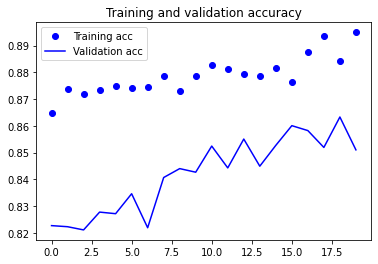

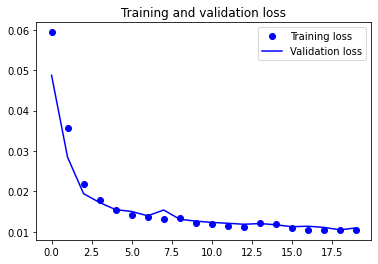

In [ ]:
# Plot accuracy and loss for training and validation sets
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:

# Functions to convert images to 3D (image_dim, image_dim, 3) 
# or 4D (1, image_dim, image_dim, 3) tensors

image_dimension = 300

def image_to_3d_tensor(image_path):
    im = cv2.resize(cv2.imread(image_path), (image_dimension, image_dimension)).astype(np.float32)
    return im/255

def image_to_4d_tensor(image_path):
    im = image_to_3d_tensor(image_path)
    im = im.reshape(1, image_dimension, image_dimension, 3)
    return im

# def 3d_tensor_to_image(tensor):
#   im = cv2.resize(cv2.imread(image_path), (image_dimension, image_dimension)).astype(np.float32)
#   return im/255

In [ ]:

# Corpus directory
corpus_image_directory = allimage_directory
corpus_image_count = len([name for name in os.listdir(corpus_image_directory)])
print(corpus_image_count)

2023


In [ ]:

# Instantiate tensors array and list of filenames
corpus_tensors = np.zeros((1, image_dimension, image_dimension, 3))
corpus_tensors_list = []
corpus_filenames = []

In [ ]:

# Create image tensors and filename list
for filename in os.listdir(corpus_image_directory):
    corpus_filenames.append(filename)
    try: 
        corpus_tensors_list.append(image_to_3d_tensor(corpus_image_directory + filename))
    except: 
        pass
    if len(corpus_tensors_list) % 100 == 0: print('Processed:', len(corpus_tensors_list)) 
corpus_tensors = np.array(corpus_tensors_list)

Processed: 100
Processed: 200
Processed: 300
Processed: 400
Processed: 500
Processed: 600
Processed: 700
Processed: 800
Processed: 900
Processed: 1000
Processed: 1100
Processed: 1200
Processed: 1300
Processed: 1400
Processed: 1500
Processed: 1600


In [ ]:
# Save tensors and filenames
pickle.dump(corpus_tensors, open('/content/drive/My Drive/ds/pizza_images/autoencoder/corpus_tensors1.pickle', 'wb'), protocol=4)
pickle.dump(corpus_filenames, open('/content/drive/My Drive/ds/pizza_images/autoencoder/corpus_filenames1.pickle', 'wb'))

In [ ]:
# View dimensions of corpus tensors
corpus_tensors.shape

(2023, 300, 300, 3)

In [ ]:
# Predict feature values using narrow encoded layer
corpus_features = feature_extractor.predict(corpus_tensors, verbose=1)

64/64 [==============================] - 341s 5s/step


In [ ]:
# Save corpus features
pickle.dump(corpus_features, open('/content/drive/My Drive/ds/pizza_images/autoencoder/corpus_features1.pickle', 'wb'), protocol=4)

In [ ]:
corpus_tensors = pickle.load(open('/content/drive/My Drive/ds/pizza_images/autoencoder/corpus_tensors1.pickle','rb'))
corpus_filenames = pickle.load(open('/content/drive/My Drive/ds/pizza_images/autoencoder/corpus_filenames1.pickle','rb'))
corpus_features = pickle.load(open('/content/drive/My Drive/ds/pizza_images/autoencoder/corpus_features1.pickle','rb'))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_orig_and_encoded(image):
    orig = image_to_3d_tensor(image)
    pred = autoencoder.predict(orig.reshape(1, image_dimension, image_dimension, 3))\
            .reshape(image_dimension, image_dimension, 3)
    # print(orig.shape, pred.shape)
    plt.figure(figsize=(12, 10))
    plt.subplot(221)
    plt.imshow(orig)
    plt.title('Original')
    plt.subplot(222)
    plt.imshow(pred)
    plt.title('Encoded')

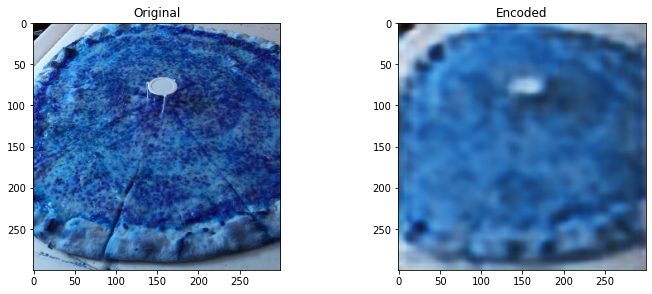

In [ ]:
display_orig_and_encoded('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg')

In [ ]:
test_image_file = '/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg'
orig = image_to_3d_tensor(test_image_file)
pred = autoencoder.predict(orig.reshape(1, image_dimension, image_dimension, 3))\
        .reshape(image_dimension, image_dimension, 3)
# print(orig.shape, pred.shape)


# im = Image.open(test_image_file)
# im.show()
# # display(Image(test_image_file, width = image_dimension, height = image_dimension))

# # Predict feature values for test image
# test_tensor = image_to_4d_tensor(test_image_file)
# test_features = feature_extractor.predict(test_tensor)
# test_features[0]

In [ ]:
def compare_test_image(test_image_file, metric='cosine'):
    
    # Display original image
    print('Original image')
    im = Image.open(test_image_file)
    im.show()
    # display(Image(test_image_file, width = image_dimension, height = image_dimension))
    
    # Predict feature values for test image
    test_tensor = image_to_4d_tensor(test_image_file)
    test_features = feature_extractor.predict(test_tensor)
    
    # Use a vectorized function (spatial.distance.cdist) to calculate the distance between
    # the test image and each of the images in the corpus.
    # Images need to be converted to '2d' for use in distance.cdist.
    # First dimension is number of images (1 for test, corpus size for corpus).
    # Second dimension is width x height x number of color channels.
    test_features_2d = np.reshape(test_features, (test_features.shape[0], test_features.shape[1] * test_features.shape[2] * test_features.shape[3]))
    corpus_features_2d = np.reshape(corpus_features, (corpus_features.shape[0], corpus_features.shape[1] * corpus_features.shape[2] * corpus_features.shape[3]))
    
    # Run comparison
    distance_array = spatial.distance.cdist(test_features_2d, corpus_features_2d, metric=metric)

    # If #1 best match is indistinguishable from test image, skip 
    shift = 0
    if np.min(distance_array) < .001: shift = 1
        
    # Return top 5 id numbers using argsort
    top5ids = [corpus_filenames[index] for index in distance_array.argsort()[0][0+shift:5+shift].tolist()]
    top5list = []
    
    print('Closest matches')
    # for index, value in enumerate(top5ids):
    #     pizza = {}
    #     pizza['order'] = index
    #     pizza['image_url'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'image_url'].item()
    #     artwork['artist'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'artist'].item()
    #     artwork['title'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'title'].item()
    #     artwork['date'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'date'].item()
    #     artwork['medium'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'medium'].item()
    #     artwork['page_url'] = corpus_metadata.loc[corpus_metadata['id'] == top5ids[index], 'page_url'].item()
    #     artwork['resubmit'] = 'placeholder'
    #     top5list.append(artwork)
    #     display(Image(url = artwork['image_url'], format = 'jpg', width = image_dimension, height = image_dimension))
    return(top5ids)

In [ ]:
# Execute comparison for test image.
top5 = compare_test_image('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg')

Original image
Closest matches


In [ ]:
top5

['bellonas-pizza-chicago_0.jpeg',
 'lonnies-pizzaria-chicago_5.jpeg',
 'calo-ristorante-chicago_4.jpeg',
 'cochiaros-pizza-chicago_2.jpeg',
 'giordanos-chicago_4.jpeg']

In [ ]:
ims =[]
for image in top5:
  im = Image.open(os.path.join('/content/drive/MyDrive/ds/pizza_images/all_images',image))
  ims.append(im)

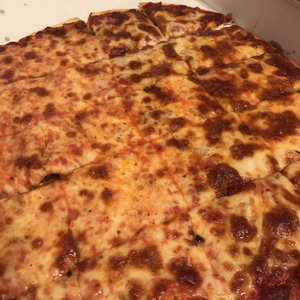

In [ ]:
ims[0]

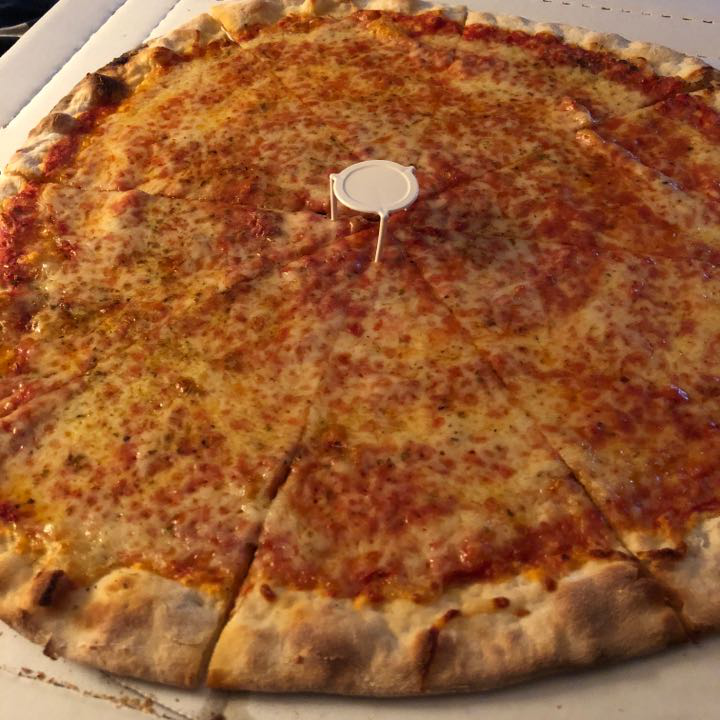

In [ ]:
Image.open('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg')

In [ ]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(new_pizza):
    top5 = compare_test_image(new_pizza)
    images =[]
    images.append(Image.open(new_pizza))
    for image in top5:
      im = Image.open(os.path.join('/content/drive/MyDrive/ds/pizza_images/all_images/data',image))
      images.append(im)
    plt.figure(figsize=(20, 10))
    titles = ['Your Input']
    titles = titles.append(top5)
    columns = 6
    for i, image in enumerate(images):
        ax = plt.subplot((len(images)+1) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + 'Your Input')
        else:
            ax.set_title("Similar Image\n" + top5[i-1])
        plt.imshow(image)

Original image
Closest matches


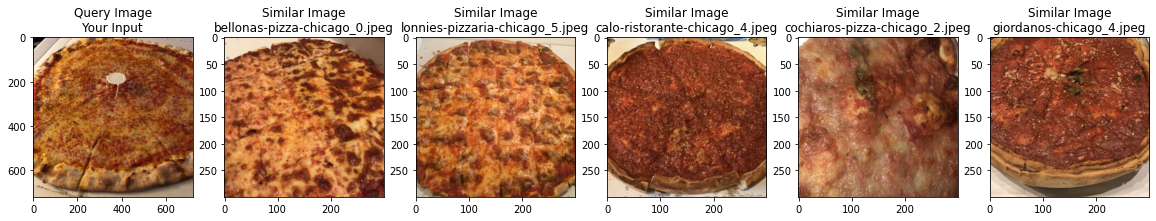

In [ ]:
plot_images('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg')

In [ ]:
plot_images('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test2.jpg')

Original image
Closest matches


FileNotFoundError: ignored